![download.png](download.png)


## Import Packages

In [97]:
#Import Python packages
import pandas as pd
import plotly.express as px
import json
import sys
import cachetools
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import numpy as np
import json
import datetime

# for splitting of the dataset
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate

# for encoding/transforming the data
from feature_engine.encoding import OneHotEncoder

#ML-Models: Classification
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn import tree
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn. ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn. ensemble import AdaBoostClassifier


# for getting metrics
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score

# model selection
from sklearn.model_selection import GridSearchCV

# Import Snowflake modules
from snowflake.snowpark import Session
import snowflake.snowpark.functions as F
import snowflake.snowpark.types as T
from snowflake.snowpark import Window

## Connect to Snowflake

In [42]:
# Get account credentials from a json file
with open("data_scientist_auth.json") as f:
    data = json.load(f)
    username = data["username"]
    password = data["password"]
    account = data["account"]

# Specify connection parameters
connection_parameters = {
    "account": account,
    "user": username,
    "password": password,
    "role": "TASTY_BI",
    "warehouse": "TASTY_BI_WH",
    "database": "frostbyte_tasty_bytes",
    "schema": "analytics",
}

# Create Snowpark session
session = Session.builder.configs(connection_parameters).create()

## Gathering Data as Snowpark DataFrame

In [43]:
#Orders_V
tasty_bytes_orders_v = session.table("frostbyte_tasty_bytes.analytics.orders_v")
#Customer Loyalty
tasty_bytes_customer_loyalty = session.table("frostbyte_tasty_bytes.raw_customer.customer_loyalty")

## Data Exploration 
*To choose which country to work on*

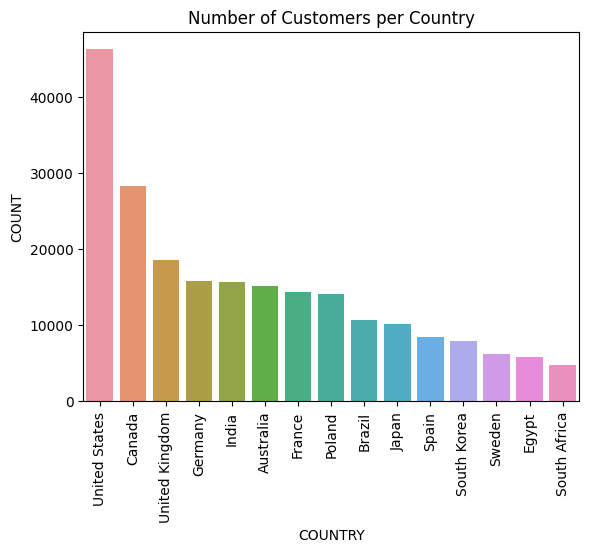

In [73]:
#Unique members
temp_df=tasty_bytes_customer_loyalty.group_by(F.col('Country')).count().to_pandas().sort_values(by='COUNT',ascending=False)
sns.barplot(x='COUNTRY',y='COUNT',data=temp_df)
plt.xticks(rotation=90)
plt.title('Number of Members per Country')
plt.show()

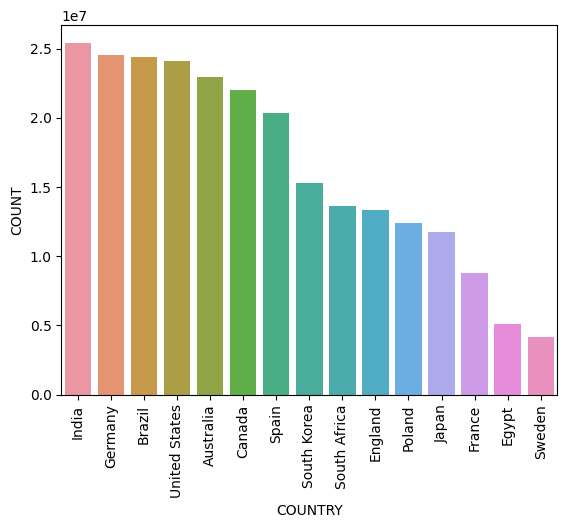

In [74]:
#Number of unique transactions
temp_df=tasty_bytes_orders_v.group_by(F.col('COUNTRY')).agg(F.countDistinct('ORDER_ID').alias('COUNT')).to_pandas().sort_values(by='COUNT',ascending=False)
sns.barplot(x='COUNTRY',y='COUNT',data=temp_df)
plt.xticks(rotation=90)
plt.title('')
plt.show()

In [76]:
#Get last transaction date for each country
last_tran_country = tasty_bytes_orders_v.group_by(F.col('COUNTRY')).max(F.to_date(F.col('ORDER_TS'))).to_pandas()

#Get assumed churned date which is two weeks before last transaction date, then get total number of customers in the assumed time period
last_tran_country['CHURN_DATE']=last_tran_country['MAX(TO_DATE(ORDER_TS))']-datetime.timedelta(days=14)
last_tran_country['CUSTOMER_COUNT_DATE']=last_tran_country['MAX(TO_DATE(ORDER_TS))']-datetime.timedelta(days=44)

#Make pandas dataframe into a snowpark dataframe
last_tran_country_sdf=session.createDataFrame(last_tran_country)

#Merge 
last_tran_country_sdf_join = last_tran_country_sdf.join(
    right=tasty_bytes_orders_v,
    on="COUNTRY",
    how="inner"
)


#Filter dataframe to the assumed time period
df = last_tran_country_sdf_join[last_tran_country_sdf_join["DATE"] > last_tran_country_sdf_join["CUSTOMER_COUNT_DATE"]]
df.show()

#Filter to get churned members dataset
df2 = df[last_tran_country_sdf_join["DATE"] > last_tran_country_sdf_join["CHURN_DATE"]]

#Number of customers before churn date
cust_bef = df.groupBy("COUNTRY").agg(F.countDistinct(F.col("CUSTOMER_ID")).alias('COUNT_BEF'))
#Number of customers after churn date
cust_aft = df2.groupBy("COUNTRY").agg(F.countDistinct(F.col("CUSTOMER_ID")).alias('COUNT_AFT'))

#Merge
calculator = cust_aft.join(
    right=cust_bef,
    on="COUNTRY",
    how="inner"
)
calc = calculator.to_pandas()

#Calculate Churn rate 
calc["CHURN_RATE"] = (((calc["COUNT_BEF"] - calc["COUNT_AFT"]) / calc["COUNT_BEF"]) * 100)
temp_df=calc.sort_values(by='CHURN_RATE',ascending=False)

---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"COUNTRY"  |"MAX(TO_DATE(ORDER_TS))"  |"CHURN_DATE"  |"CUSTOMER_COUNT_DATE"  |"DATE"      |"ORDER_ID"  |"TRUCK_ID"  |"ORDER_TS"           |"ORDER_DETAIL_ID"  |"LINE_NUMBER"  |"TRUCK_BRAND_NAME"  |"MENU_TYPE"   |"PRI

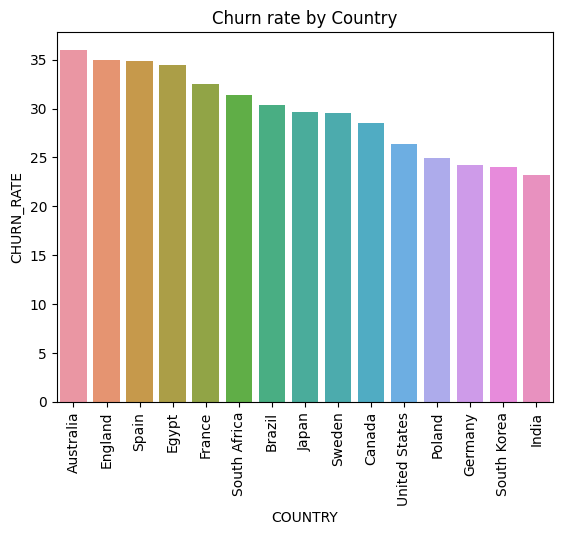

In [77]:
#Churn rate by Country
sns.barplot(x='COUNTRY',y='CHURN_RATE',data=temp_df)
plt.xticks(rotation=90)
plt.title('Churn rate by Country')
plt.show()

We decided to work on United States as it has the most number of customers, a high number of customers and quite a high Churn Rate.

## Preparing the table for Modelling

In [44]:
#Filter to only Australia
filtered_df=tasty_bytes_orders_v.filter(F.col('COUNTRY')=='United States')

#Merge to get loyal customers orders
loyal_customer_orders=tasty_bytes_customer_loyalty.join(
    right=filtered_df,
    on="CUSTOMER_ID",
    how="inner"
)
loyal_customer_orders.show()
print('Number of rows:',loyal_customer_orders.count())

----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [45]:
#Function to remove and rename columns after inner join
def remove_dup_join_col(df):
    # capitalise all columns
    for col in df.columns:
        df = df.withColumnRenamed(col, col.upper())
    
    # get list of renamable columns for left and right join
    left_dup_col = [col_name for col_name in df.columns if col_name.startswith('L_')]
    right_dup_col = [col_name for col_name in df.columns if col_name.startswith('R_')]
    old_columns = df.columns
    
    # rename the list with the most number of renamable columns
    # drop the list of columns with less number of renamable columns
    if len(left_dup_col)>len(right_dup_col):
        columns_rename=left_dup_col
        df= df.drop(*right_dup_col)
    else:
        columns_rename=right_dup_col
        df= df.drop(*left_dup_col)
    
    for old_column in old_columns:
        if old_column in columns_rename:
            # get string to remove
            string_to_replace = columns_rename[0][:7]
            # replace starting string
            new_column = old_column.replace(string_to_replace, "")
            df = df.withColumnRenamed(old_column, new_column)
    
    return df

In [46]:
#Remove duplicate columns
loyal_customer_orders = remove_dup_join_col(loyal_customer_orders)
loyal_customer_orders.show()

---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"CUSTOMER_ID"  |"CITY"         |"POSTAL_CODE"  |"PREFERRED_LANGUAGE"  |"FAVOURITE_BRAND"  |"SIGN_UP_DATE"  |"BIRTHDAY_DATE"  |"DATE"      |"ORDER_ID"  |"TRUCK_ID"  |"ORDER_TS"          

In [47]:
#Total Quantity of each order
temp_df=loyal_customer_orders.group_by(F.col('ORDER_ID')).agg(F.sum(F.col('QUANTITY')).alias('Total_Quantity'))

#Remove duplicate order ids
remove_dup = loyal_customer_orders.dropDuplicates(['ORDER_ID'])

#Merge to get transactions table
combined_df=remove_dup.join(
    right=temp_df,
    on="ORDER_ID",
    how="inner"
)
combined_df.show()

-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"ORDER_ID"  |"CUSTOMER_ID"  |"CITY"         |"POSTAL_CODE"  |"PREFERRED_LANGUAGE"  |"FAVOUR

In [48]:
# assuming you have a DataFrame called `orders` with columns `customer_id` and `order_ts`
window_spec = Window.partitionBy('customer_id').orderBy(F.col('order_ts').desc())

orders_with_rank = combined_df.withColumn('rank', F.rank().over(window_spec))

#Get max order of each customer
max_order_ts = orders_with_rank.filter(F.col('rank') == 1).select('customer_id', 'order_ts').to_pandas()
max_order_ts =max_order_ts.drop_duplicates()

#Get second max order of each customer
second_max_order_ts = orders_with_rank.filter(F.col('rank') == 2).select('customer_id', 'order_ts').to_pandas()
second_max_order_ts =second_max_order_ts.drop_duplicates()

In [49]:
#Rename columns
second_max_order_ts=second_max_order_ts.rename(columns={'ORDER_TS':'2ndMax_Order_TS'})
max_order_ts =max_order_ts.rename(columns={'ORDER_TS':'Max_Order_TS'})

In [50]:
#Loyal Orders Pandas
loyal_orders_df=combined_df.to_pandas()

#Merge with secon max order dataframe
temp_df=loyal_orders_df.merge(second_max_order_ts,on='CUSTOMER_ID',how='inner')

#Filter out Last Purchase
filtered_df=temp_df[temp_df['ORDER_TS']<=temp_df['2ndMax_Order_TS']]

### Feature Engineering: Adding RFM Columns

In [54]:
# Recency
recency = filtered_df.groupby('CUSTOMER_ID')['ORDER_TS'].max().reset_index()
recency['RECENCY'] = (pd.Timestamp('2022-11-01 22:42:53') - recency['ORDER_TS']).dt.days

# Frequency
frequency = filtered_df.groupby('CUSTOMER_ID')['ORDER_ID'].nunique().reset_index().rename(columns={'ORDER_ID': 'frequency'})

# Monetary
monetary = filtered_df.groupby('CUSTOMER_ID')['ORDER_TOTAL'].sum().reset_index().rename(columns={'ORDER_TOTAL': 'monetary'})

# Merge into RFM table
RFM_table = recency.merge(right=frequency, how='inner', on='CUSTOMER_ID')
RFM_table = RFM_table.merge(right=monetary, how='inner', on='CUSTOMER_ID')

### Feature Engineering: Adding Average Time Difference, Max and Min Days without Purchase

In [55]:
#Sort the orders based on Customer ID and Order Date
temp_df = filtered_df.sort_values(['CUSTOMER_ID', 'ORDER_TS'])

# Calculate the time difference between consecutive 'ORDER_TS' values for each customer
temp_df['time_diff'] = temp_df.groupby('CUSTOMER_ID')['ORDER_TS'].diff().dt.days

# Calculate the mean time difference for each customer
avg_time_diff = temp_df.groupby('CUSTOMER_ID')['time_diff'].mean().reset_index().rename(columns={'time_diff': 'AVG_TIME_DIFF'})

#Max Days without Purchase
max_days=temp_df.groupby('CUSTOMER_ID')['time_diff'].max().reset_index().rename(columns={'time_diff': 'Max_Days_Without_Purchase'})

#Min Days without Purchase
min_days=temp_df.groupby('CUSTOMER_ID')['time_diff'].min().reset_index().rename(columns={'time_diff': 'Min_Days_Without_Purchase'})

In [88]:
#Merge to get final dataframe
final_df=RFM_table.merge(right=max_order_ts,how='inner',on='CUSTOMER_ID')
final_df=final_df.merge(right=avg_time_diff,how='inner',on='CUSTOMER_ID')
final_df=final_df.merge(right=max_days,how='inner',on='CUSTOMER_ID')
final_df=final_df.merge(right=min_days,how='inner',on='CUSTOMER_ID')

In [89]:
#Add Days To Next Order
final_df['Days_To_Next_Order']=(final_df['Max_Order_TS']-final_df['ORDER_TS']).dt.days

In [90]:
#Describe the target
final_df['Days_To_Next_Order'].describe()

count    46300.000000
mean        12.073758
std         12.849471
min          0.000000
25%          3.000000
50%          8.000000
75%         16.000000
max        174.000000
Name: Days_To_Next_Order, dtype: float64

In [91]:
#Add Target Variable Next Purchase Day Range 
final_df['NextPurchaseDayRange'] = 1
final_df.loc[final_df['Days_To_Next_Order']<=8,'NextPurchaseDayRange'] = 0

<Axes: xlabel='NextPurchaseDayRange', ylabel='count'>

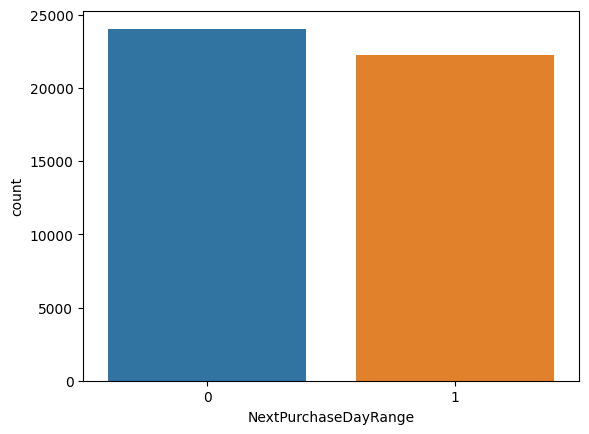

In [92]:
#Distribution of target variable
sns.countplot(data=final_df,x='NextPurchaseDayRange')
plt.show()

In [69]:
# Define Model Inputs (X) and Output (y)
X = final_df.drop(['Days_To_Next_Order','NextPurchaseDayRange','Max_Order_TS','ORDER_TS'], axis =1)
y = final_df["NextPurchaseDayRange"]

# Split both Inputs (X) and Ouput (y) into training set (70%) and testing set (30%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=4)

## Model Building

In [95]:
#Function to show MSE, MAE, r-sq of Classification models
def evaluateClassificationModelPerformance(model):
    #Accuracy
    print('Train Accuracy:',model.score(X_train, y_train),
          '\nTest Accuracy:',model.score(X_test, y_test))

In [99]:
#Build Logistic Regression Model
lr = LogisticRegression(max_iter=10000)
lr.fit(X_train, y_train)

evaluateClassificationModelPerformance(lr)

Train Accuracy: 0.7469916692378895 
Test Accuracy: 0.7546436285097192


In [98]:
#Build Decision Tree Model
tree = tree.DecisionTreeClassifier(max_depth = 20)

tree.fit(X_train, y_train)

evaluateClassificationModelPerformance(tree)

Train Accuracy: 0.9030854674483184 
Test Accuracy: 0.7082793376529878


In [100]:
#Build MLP model
ANN_model = MLPClassifier(activation ='logistic', hidden_layer_sizes=(10,), max_iter= 2000, solver = 'sgd', random_state=2)

ANN_model.fit(X_train, y_train)

evaluateClassificationModelPerformance(ANN_model)

Train Accuracy: 0.5173711817340327 
Test Accuracy: 0.5245500359971202


In [104]:
#Build Random Forest Model

rf= RandomForestClassifier(n_estimators=100)
rf.fit(X_train, y_train)

evaluateClassificationModelPerformance(randomFr)

Train Accuracy: 1.0 
Test Accuracy: 0.7637868970482361


In [102]:
#Build Ada Boost Model
adb = AdaBoostClassifier(DecisionTreeClassifier(),n_estimators=5,learning_rate=1)
adb.fit(X_train, y_train)

evaluateClassificationModelPerformance(adb)

Train Accuracy: 1.0 
Test Accuracy: 0.6806335493160547


In [70]:
#Build XGBoost Model
xgb = XGBClassifier(n_estimators = 20, learning_rate = 0.1, eval_metric='logloss')
xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=20, n_jobs=None,
              num_parallel_tree=None, predictor=None, random_state=None, ...)

In [71]:
#Evaluate XGBoost Model
evaluateClassificationModelPerformance(xgb)

Train Accuracy: 0.7752854057389694 
Test Accuracy: 0.7709143268538516


In [93]:
#Check top 10 features based on feature importance
ft_weights_xgb_clf = pd.DataFrame(xgb.feature_importances_, columns=['is_promoted'], index=X_train.columns)
ft_weights_xgb_clf.sort_values('is_promoted', ascending=False, inplace=True)
ft_weights_xgb_clf.tail(100)

,is_promoted
RECENCY,0.943381
AVG_TIME_DIFF,0.012582
CUSTOMER_ID,0.011237
monetary,0.010758
Max_Days_Without_Purchase,0.010199
frequency,0.007962
Min_Days_Without_Purchase,0.003881


## Improving the model

#### Random Forest

In [106]:
# Perform Cross Validation
X = pd.concat([X_train, X_test], axis=0)
y = pd.concat([y_train, y_test], axis=0)


# Evaluate the Model using K-folds Cross validation
results  = cross_validate(rf, X, y, scoring='accuracy', cv=6, return_train_score = True)
print('train_score: ', results['train_score'])
print('test_score: ', results['test_score'])


print('cross val training accuracy is:', sum(results['train_score'])/len(results['train_score']))
print('cross val testing accuracy is:', sum(results['test_score'])/len(results['test_score']))

train_score:  [1.         1.         0.99994816 0.99997408 1.         0.99997408]
test_score:  [0.74394195 0.75249449 0.76778541 0.76169496 0.76296008 0.75894246]
cross val training accuracy is: 0.9999827213449682
cross val testing accuracy is: 0.7579698912042715


In [107]:
# Grid Search
rf = RandomForestClassifier(max_features='auto', random_state=1, n_jobs=-1)

param_grid = { "criterion" : ["gini", "entropy"], 
              "max_depth": [2, 4, 6], 
              "min_samples_leaf" : [1, 5], 
              "n_estimators": [10, 20]}

gs = GridSearchCV(estimator=rf, param_grid=param_grid, scoring='accuracy', cv=6, n_jobs=-1)

gs = gs.fit(X, y)

print(gs.best_score_)
print(gs.best_params_)

0.7666523098662177
{'criterion': 'gini', 'max_depth': 6, 'min_samples_leaf': 1, 'n_estimators': 20}


c:\Users\ryanl\anaconda3\envs\py38_env\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


In [108]:
rf_final = RandomForestClassifier(criterion='gini', 
                             n_estimators=20,
                             max_depth=6,
                             min_samples_leaf=1,
                             max_features='auto',                             
                             random_state=1,
                             n_jobs=-1)

rf_final.fit(X_train,y_train)

print('***Final Model***')
print('training acc: ', rf_final.score(X_train,y_train))
print('testing acc: ', rf_final.score(X_test,y_test))
results  = cross_validate(rf_final, X, y, scoring='accuracy', cv=6, return_train_score = True)
print('cross val training accuracy is:', sum(results['train_score'])/len(results['train_score']))
print('cross val testing accuracy is:', sum(results['test_score'])/len(results['test_score']))


c:\Users\ryanl\anaconda3\envs\py38_env\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
c:\Users\ryanl\anaconda3\envs\py38_env\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


***Final Model***
training acc:  0.7683122493057698
testing acc:  0.7676745860331173


c:\Users\ryanl\anaconda3\envs\py38_env\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
c:\Users\ryanl\anaconda3\envs\py38_env\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
c:\Users\ryanl\anaconda3\envs\py38_env\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this para

cross val training accuracy is: 0.769969777200116
cross val testing accuracy is: 0.7666523098662177


## Reset

In [ ]:
"""# Drop training table
session.sql("DROP TABLE IF EXISTS frostbyte_tasty_bytes.analytics.shift_sales_train").collect()

# Drop testing table
session.sql("DROP TABLE IF EXISTS frostbyte_tasty_bytes.analytics.shift_sales_test").collect()

# Drop training stored procedure
session.sql("DROP PROCEDURE IF EXISTS sproc_train_linreg(varchar, array, varchar, varchar)").collect()

# Drop inference user-defined function
session.sql(
    "DROP FUNCTION IF EXISTS udf_linreg_predict_location_sales(float, float, float, float, float, float, float, float)"
).collect()

# Drop stage
session.sql("DROP STAGE IF EXISTS model_stage").collect()

# Scale down compute
session.sql("ALTER WAREHOUSE tasty_ds_wh SET WAREHOUSE_SIZE = XSMALL").collect()

# Close the session
session.close()"""